# Analyze RNA tetramers (vanilla)

1. report acceptance/proposal ratio
2. plot replica mixing heat map
3. plot radius of gyration (Rg) histogram
4. plot rmsd (all, backbone only)
5. calculate J-coupling
6. bar plot of conformation population

### Userful links
- [Description of the 7 torsions in RNA](http://dssr.bio.columbia.edu/data/backbone-torsion.jpg)
- [RNA 3D Course by by Craig L. Zirbel and Neocles Leontis at Bowling Green State University](https://docs.google.com/document/d/173tvcKJgAUmjd03zIKLz-_KCNTlcHBNDWlDfDtMhxmU/edit)  
- [Stacking in RNA: NMR of Four Tetramers Benchmark Molecular Dynamics, JCTC 2015](https://pubs.acs.org/doi/10.1021/ct501025q)  
- [Barnaba: software for analysis of nucleic acid structures and trajectories, RNA 2019](https://rnajournal.cshlp.org/content/25/2/219.full)  

In [1]:
import os, sys, math
import numpy as np
import glob
import mdtraj
import logging
import netCDF4 as nc
import warnings
import pandas as pd
#from IPython.display import display

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
import seaborn as sns

#import openmmtools as mmtools
#from pymbar import timeseries
#from openmm import *
#from openmm.app import *
#from openmm.unit import *

import barnaba as bb
from barnaba import definitions
from barnaba.nucleic import Nucleic

In [2]:
logger = logging.getLogger(__name__)
warnings.filterwarnings("ignore")

In [15]:
pd.options.display.max_rows = None
pd.options.display.max_columns = None
pd.options.display.precision = 1
pd.options.display.float_format = '{:.1f}'.format

In [16]:
#plt.rcParamsDefault

In [17]:
params = {'legend.fontsize': 40, 
          'font.size': 40, 
          'axes.labelsize': 48,
          'axes.titlesize': 48,
          'xtick.labelsize': 40,
          'ytick.labelsize': 40,
          'savefig.dpi': 600, 
          'figure.figsize': [64, 8],
          'xtick.major.size': 10,
          'xtick.minor.size': 7,
          'ytick.major.size': 10,
          'ytick.minor.size': 7}

plt.rcParams.update(params)

In [18]:
backbone_sugar_atoms = [
    "C1'", \
    "H1'", \
    "C2'", \
    "H2'", \
    "C3'", \
    "H3'", \
    "C4'", \
    "H4'", \
    "C5'", \
    "H5'", \
    "H5''", \
    "O2'", \
    "HO2'", \
    "O3'", \
    "O4'", \
    "O5'", \
    "P", \
    "OP1", \
    "OP2", \
    "HO5'", \
    "HO3'"
]

In [19]:
backbone_annot_dict = {}
backbone_annot_dict["alpha"]=0
backbone_annot_dict["beta"]=1
backbone_annot_dict["gamma"]=2
backbone_annot_dict["delta"]=3
backbone_annot_dict["eps"]=4
backbone_annot_dict["zeta"]=5
backbone_annot_dict["chi"]=6

# Define parameters

In [20]:
PLOT_TITLE = "CCCC Amber ff14"
UNIT_NM_TO_ANGSTROMS = 10
UNIT_PS_TO_NS = 1/1000
CHECKPOINT_INTERVAL = 100  # Default: 100 (unit: ps)
STRIDE = 10                # Only read every stride-th frame. Each frame is saved 100 ps (CHECKPOINT_INTERVAL) as default.

# Load reference and trajectory files

In [28]:
# initial structure
init_pdb = "../../eq/solvated.pdb"

# reference structure
ref_pdb = "../../eq/min.pdb"
ref_traj = mdtraj.load(ref_pdb)

# equilibrated
eq_ncfile = "../../eq/traj.nc"
eq_traj = mdtraj.load(eq_ncfile, top=init_pdb)

# trajectory: 100ns each / checkpoint interval: 100ps
n = len(glob.glob("../md*"))
ncfiles = [ "../md" + str(i) + "/traj.nc" for i in range(1, n) ]
traj = mdtraj.load(ncfiles, top=init_pdb, stride=STRIDE)

#### Residue names

In [29]:
rnames = [ residue.name for residue in ref_traj.topology.residues if residue.name not in ["HOH", "NA", "CL"]]
print(rnames)

['C', 'C', 'C', 'C']


# Torsion distribution

#### Compare backbone angles for initial and minimized structure

In [30]:
cols = []
#cols.append("Residue")
cols += [ a for a in definitions.bb_angles ]

In [31]:
angles, res = bb.backbone_angles(init_pdb)

mydict = {}
for i in range(angles.shape[1]):
    vals = []
    for j in range(angles.shape[2]):
        vals.append(angles[0,i,j])
        
    # move from -pi,pi to 0-2pi range and convert radians to deg
    a = np.copy(vals)
    a[np.where(a<0.0)] += 2.*np.pi
    a *= 180.0/np.pi
    mydict[res[i]] = a
    
df = pd.DataFrame.from_dict(mydict, orient='index', columns=cols)
df

# Loading ../../eq/solvated.pdb 


,alpha,beta,gamma,delta,eps,zeta,chi
C_1_0,NaN,NaN,48.8,83.2,213.1,281.4,193.4
C_2_0,299.8,174.9,48.9,83.1,213.2,281.3,193.4
C_3_0,299.9,174.9,48.9,83.2,213.2,281.3,193.4
C_4_0,299.9,174.9,48.9,83.2,NaN,NaN,193.4


In [32]:
angles, res = bb.backbone_angles(ref_pdb)

mydict = {}
for i in range(angles.shape[1]):
    vals = []
    for j in range(angles.shape[2]):
        vals.append(angles[0,i,j])
    
    # move from -pi,pi to 0-2pi range and convert radians to deg
    a = np.copy(vals)
    a[np.where(a<0.0)] += 2.*np.pi
    a *= 180.0/np.pi
    mydict[res[i]] = a

df = pd.DataFrame.from_dict(mydict, orient='index', columns=cols)
df

# Loading ../../eq/min.pdb 


,alpha,beta,gamma,delta,eps,zeta,chi
C_1_0,NaN,NaN,66.0,82.6,213.0,283.1,223.7
C_2_0,277.9,173.4,69.4,82.7,201.3,291.9,212.3
C_3_0,272.8,181.0,60.3,78.8,197.9,288.9,214.4
C_4_0,284.8,181.6,61.5,82.4,NaN,NaN,207.2


#### backbone angle histrogram

equilibration

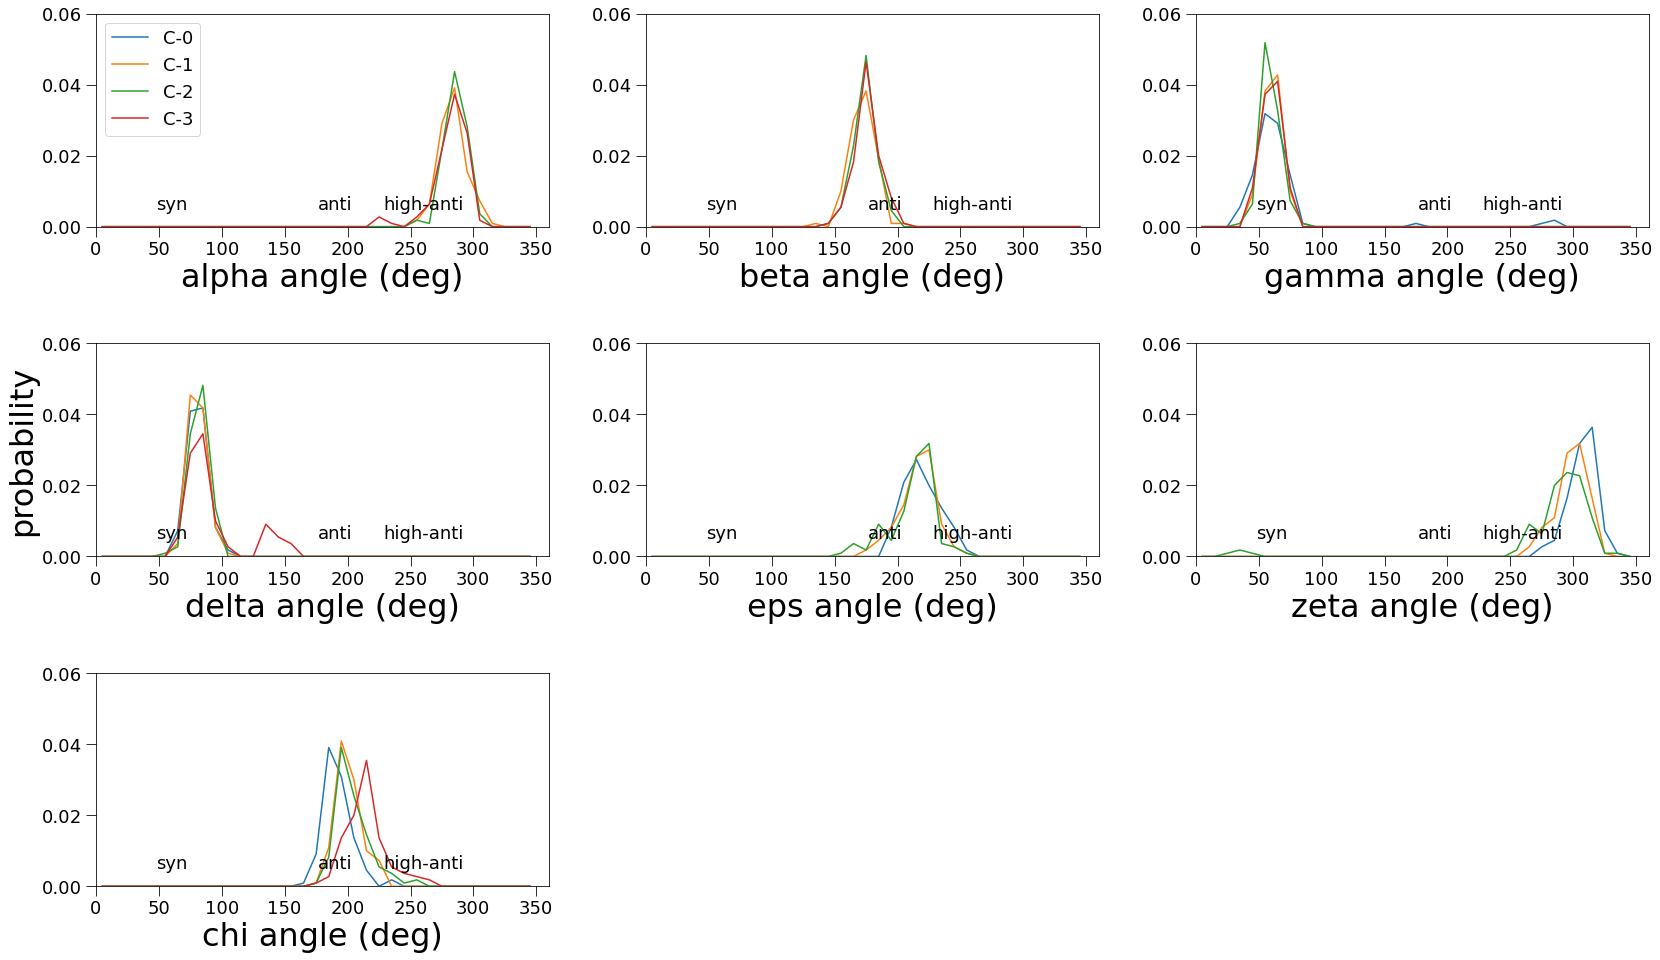

In [81]:
angles, res = bb.backbone_angles_traj(eq_traj)
#print(angles_s.shape)

# move from -pi,pi to 0-2pi range and convert radians to deg
a = np.copy(angles)
#a[np.where(a<0.0)] += 2.*np.pi
#a *= 180.0/np.pi

# convert to deg and move to 0:360 range
a = a*(180./np.pi)
a[np.where(a<0.0)] += 360

# create historgram 
bins = np.arange(0, 360, 10)

# make plot
fig = plt.figure(figsize=(24,18))
for k, v in backbone_annot_dict.items():
    """
    k : torsion name
    v : torsion index
    """
    ax = fig.add_subplot(4, 3, v+1)
    for i in range(len(rnames)):
        """
        i : residue name index
        x : normalized frequency
        y : degree
        """
        y, x = np.histogram(a[:,i, v], density=True, bins=bins)
        ax.plot(0.5*(x[1:]+x[:-1]), y, label="{}-{}".format(rnames[i], i))
    if v == 0:
        plt.legend(loc="upper left", fontsize=18)
    if v == 3:
        ax.set_ylabel("probability", fontsize=32)
    ax.set_xlabel("{} angle (deg)".format(k), fontsize=32)
    ax.set_xlim(0, 360)
    ax.set_ylim(0, 0.06)
    ax.tick_params(axis='both', labelsize=18)
    plt.text(60, 0.005, "syn", fontsize=18, ha='center')
    plt.text(190, 0.005, "anti", fontsize=18, ha='center')
    plt.text(260, 0.005, "high-anti", fontsize=18, ha='center')

plt.tight_layout()
plt.savefig("bb_angles_eq.png")

#### backbone angle histrogram

production

In [82]:
180/np.pi

57.29577951308232

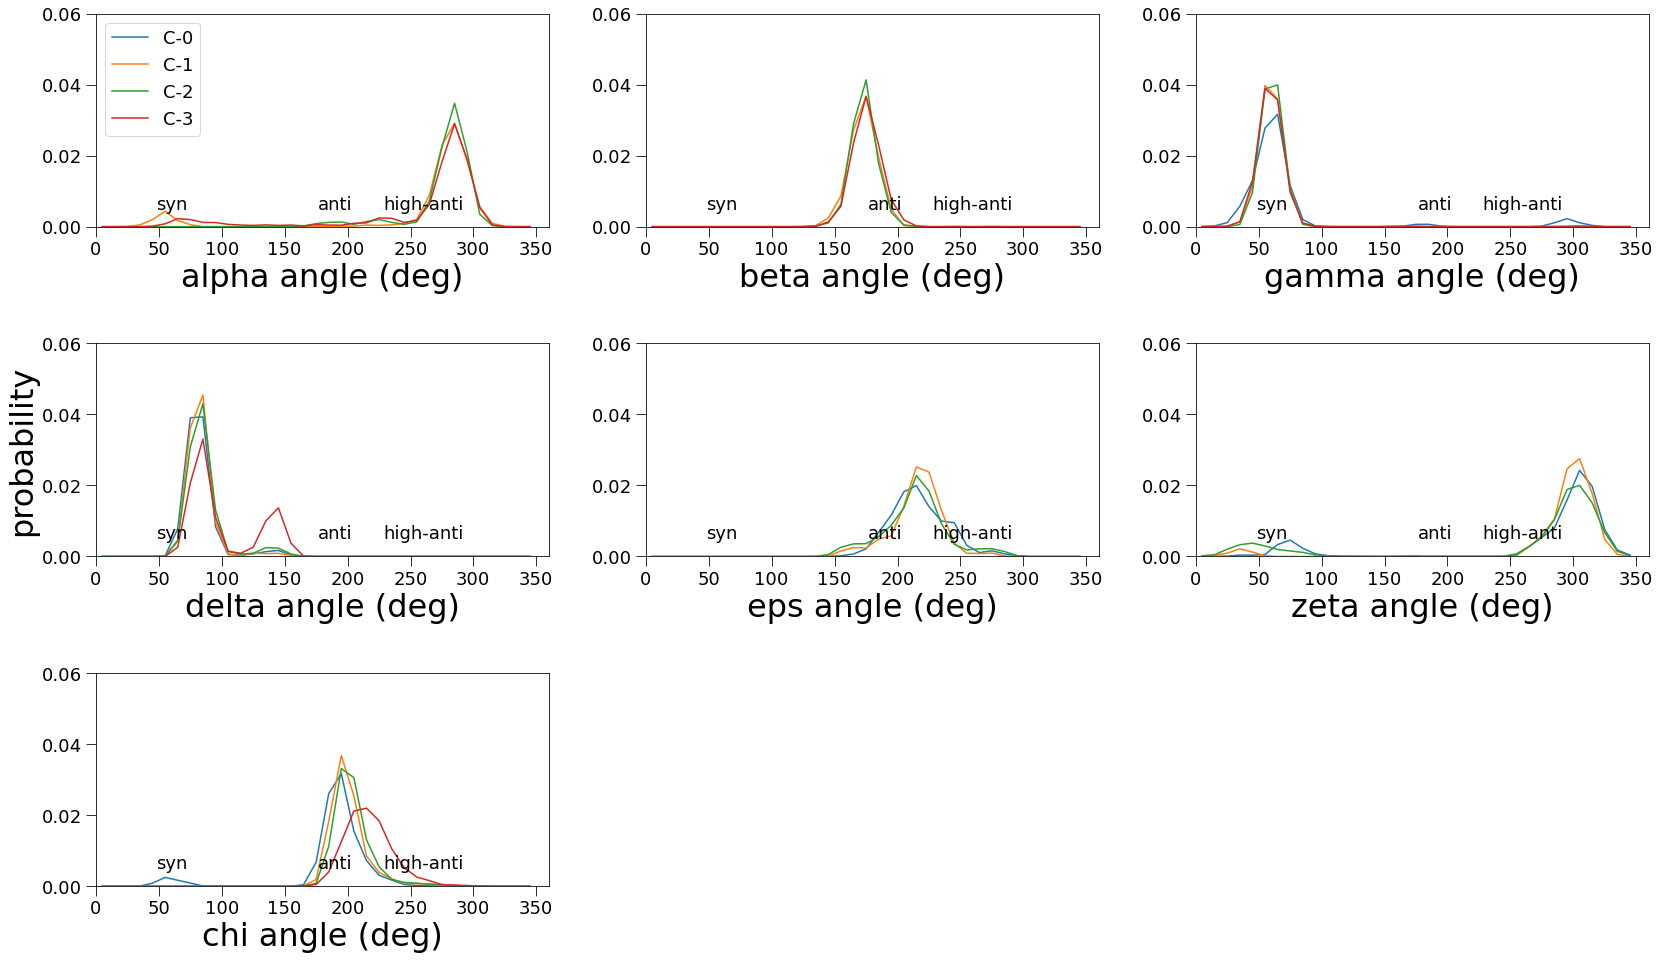

In [83]:
angles, res = bb.backbone_angles_traj(traj)
#print(angles_s.shape)

# move from -pi,pi to 0-2pi range and convert radians to deg
a = np.copy(angles)
#a[np.where(a<0.0)] += 2.*np.pi
#a *= 180.0/np.pi

# convert to deg and move to 0:360 range
a = a*(180./np.pi)
a[np.where(a<0.0)] += 360

# create historgram 
bins = np.arange(0, 360, 10)

# make plot
fig = plt.figure(figsize=(24,18))
for k, v in backbone_annot_dict.items():
    """
    k : torsion name
    v : torsion index
    """
    ax = fig.add_subplot(4, 3, v+1)
    for i in range(len(rnames)):
        """
        i : residue name index
        x : normalized frequency
        y : degree
        """
        y, x = np.histogram(a[:,i, v], density=True, bins=bins)
        ax.plot(0.5*(x[1:]+x[:-1]), y, label="{}-{}".format(rnames[i], i))
    if v == 0:
        plt.legend(loc="upper left", fontsize=18)
    if v == 3:
        ax.set_ylabel("probability", fontsize=32)
    ax.set_xlabel("{} angle (deg)".format(k), fontsize=32)
    ax.set_xlim(0, 360)
    ax.set_ylim(0, 0.06)
    ax.tick_params(axis='both', labelsize=18)
    plt.text(60, 0.005, "syn", fontsize=18, ha='center')
    plt.text(190, 0.005, "anti", fontsize=18, ha='center')
    plt.text(260, 0.005, "high-anti", fontsize=18, ha='center')

plt.tight_layout()
plt.savefig("bb_angles.png")

#### sugar pucker

initial structure

In [35]:
init_angles, res = bb.pucker_angles(init_pdb, topology=init_pdb)

# Loading ../../eq/solvated.pdb 


equilibration

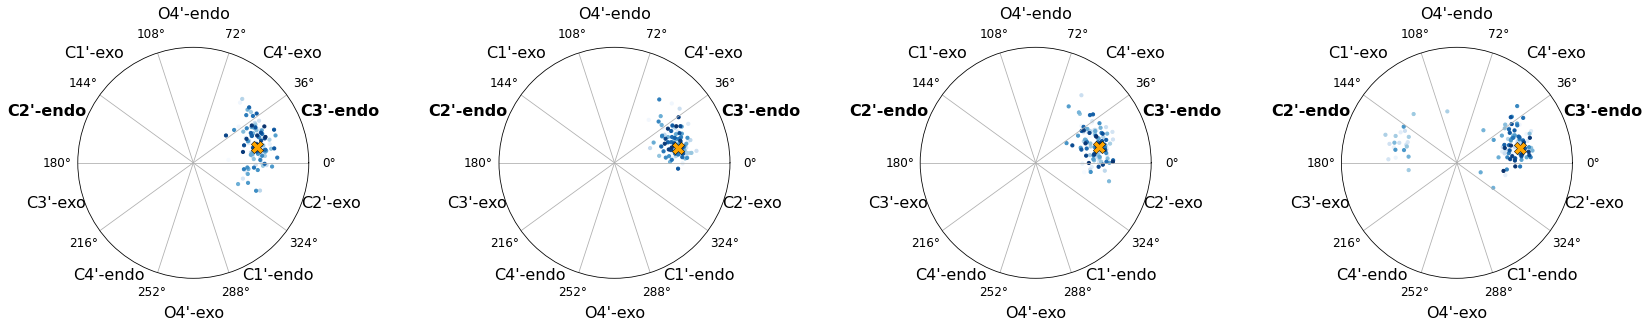

In [37]:
#angles, res = bb.pucker_angles_traj(eq_ncfile, topology=init_pdb)
angles, res = bb.pucker_rao_traj(eq_traj)

# make plot
fig = plt.figure(figsize=(24,18))
for i in range(len(rnames)):
    ax = fig.add_subplot(1, 4, i+1, polar=True)
    #ax.plot(polar=True)

    ax.scatter(angles[:,i,0], angles[:,i,1], s=10, c=np.arange(len(angles)), cmap='Blues', label="{}-{}".format(rnames[i], i))
    ax.scatter(init_angles[:,i,0], init_angles[:,i,1], marker="X", c="orange", edgecolors="black", s=150, linewidths=0.5)
    
    p3 = np.pi/5
    ax.text(0.5*p3, 1.6, "C3'-endo", ha='center', fontsize=16, fontweight='bold')
    ax.text(1.3*p3, 1.5, "C4'-exo",  ha='center', fontsize=16)
    ax.text(2.5*p3, 1.5, "O4'-endo", ha='center', fontsize=16)
    ax.text(3.7*p3, 1.5, "C1'-exo",  ha='center', fontsize=16)
    ax.text(4.5*p3, 1.6, "C2'-endo", ha='center', fontsize=16, fontweight='bold')
    ax.text(5.5*p3, 1.5, "C3'-exo",  ha='center', fontsize=16)
    ax.text(6.5*p3, 1.5, "C4'-endo", ha='center', fontsize=16)
    ax.text(7.5*p3, 1.6, "O4'-exo",  ha='center', fontsize=16)
    ax.text(8.5*p3, 1.5, "C1'-endo", ha='center', fontsize=16)
    ax.text(9.5*p3, 1.5, "C2'-exo",  ha='center', fontsize=16)
    
    xt = np.arange(0, 2*np.pi, p3)
    ax.set_xticks(xt)
    ax.set_yticks([])
    ax.set_ylim(0, 1.2)
    ax.tick_params(axis='both', labelsize=12)
    
    plt.tight_layout()
    #plt.legend(loc="upper center")
    plt.savefig("pucker_anlges_eq.png")

production

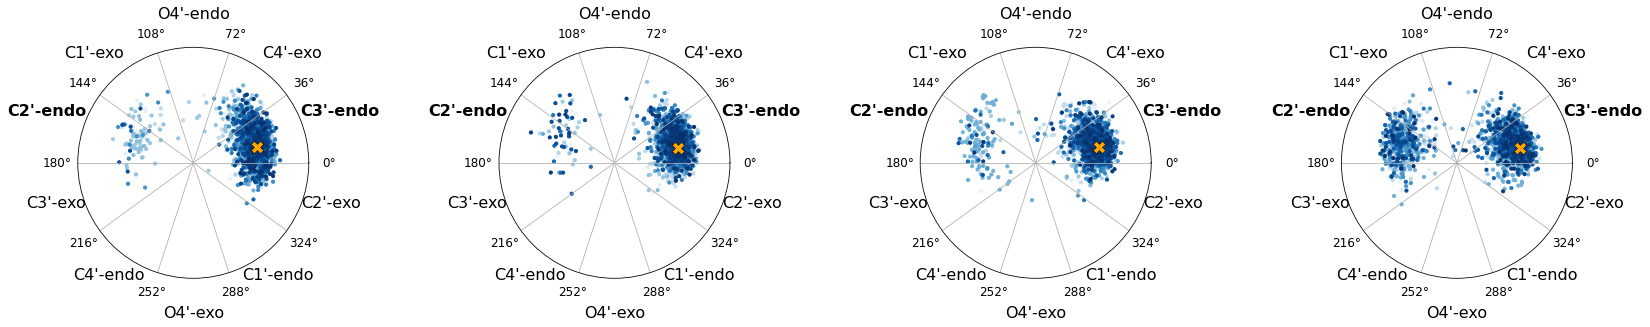

In [59]:
#angles, res = bb.pucker_angles(ncfiles, topology=init_pdb)
angles, res = bb.pucker_rao_traj(traj)

# make plot
fig = plt.figure(figsize=(24,18))
for i in range(len(rnames)):
    ax = fig.add_subplot(1, 4, i+1, polar=True)
    #ax.plot(polar=True)

    ax.scatter(angles[:,i,0], angles[:,i,1], s=10, c=np.arange(len(angles)), cmap='Blues', label="{}-{}".format(rnames[i], i))
    ax.scatter(init_angles[:,i,0], init_angles[:,i,1], marker="X", c="orange", edgecolors="black", s=150, linewidths=0.5)
    
    p3 = np.pi/5
    ax.text(0.5*p3, 1.6, "C3'-endo", ha='center', fontsize=16, fontweight='bold')
    ax.text(1.3*p3, 1.5, "C4'-exo",  ha='center', fontsize=16)
    ax.text(2.5*p3, 1.5, "O4'-endo", ha='center', fontsize=16)
    ax.text(3.7*p3, 1.5, "C1'-exo",  ha='center', fontsize=16)
    ax.text(4.5*p3, 1.6, "C2'-endo", ha='center', fontsize=16, fontweight='bold')
    ax.text(5.5*p3, 1.5, "C3'-exo",  ha='center', fontsize=16)
    ax.text(6.5*p3, 1.5, "C4'-endo", ha='center', fontsize=16)
    ax.text(7.5*p3, 1.6, "O4'-exo",  ha='center', fontsize=16)
    ax.text(8.5*p3, 1.5, "C1'-endo", ha='center', fontsize=16)
    ax.text(9.5*p3, 1.5, "C2'-exo",  ha='center', fontsize=16)
    
    xt = np.arange(0, 2*np.pi, p3)
    ax.set_xticks(xt)
    ax.set_yticks([])
    ax.set_ylim(0, 1.2)
    ax.tick_params(axis='both', labelsize=12)
    
    plt.tight_layout()
    #plt.legend(loc="upper center")
    plt.savefig("pucker_anlges.png")

# Radius of gyration

#### Rg histogram

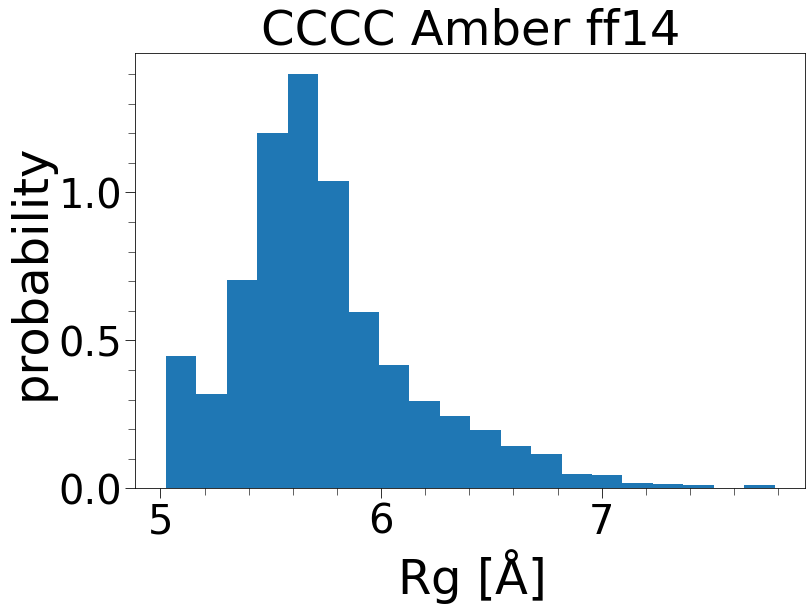

In [38]:
# calculate
atom_indices = traj.topology.select('not (protein or water or symbol Na or symbol Cl)')
t = traj.atom_slice(atom_indices)
rg = mdtraj.compute_rg(t)
rg = np.array(rg) * UNIT_NM_TO_ANGSTROMS   # convert nm to angstroms
del t

# define
fig, ax = plt.subplots(figsize=(12, 8))

# title
ax.set_title(PLOT_TITLE)

# x-axis
ax.set_xlabel(r'Rg [${\rm \AA}$]')
#ax.xaxis.set_ticks(np.arange(0, 1, 0.2))
ax.xaxis.set_minor_locator(AutoMinorLocator())
#ax.set_xlim([]) 

# y-axis
ax.set_ylabel('probability')
#ax.yaxis.set_ticks(np.arange(0, 1, 0.2))
#ax.yaxis.set_minor_locator(MultipleLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
#ax.set_ylim([])

# plot
ax.hist(rg, bins=20, density=True)

#plt.show()
plt.savefig("rg_hist.png")

#### Rg time plot

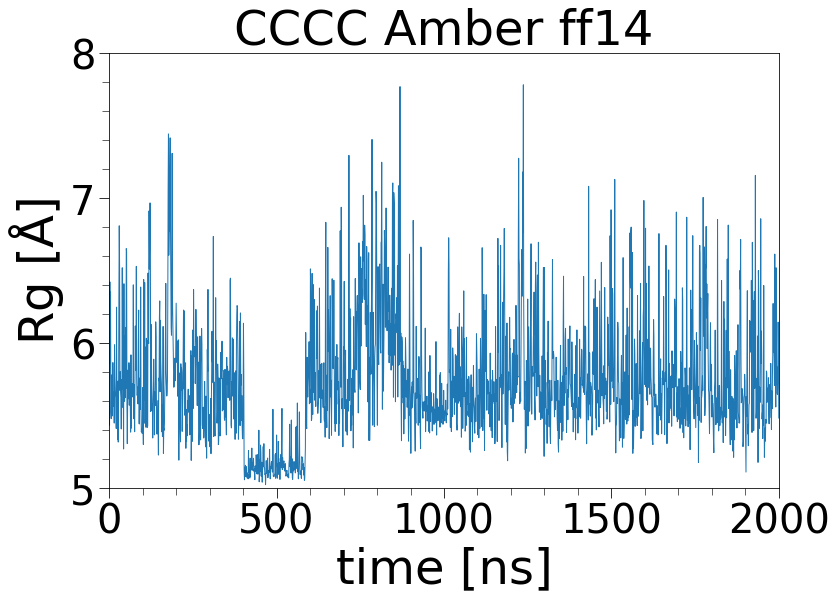

In [39]:
x = np.arange(1, len(rg)+1) * CHECKPOINT_INTERVAL * STRIDE * UNIT_PS_TO_NS

# define
fig, ax = plt.subplots(figsize=(12, 8))

# title
ax.set_title(PLOT_TITLE)

# x-axis
ax.set_xlabel(r'time [ns]')
#ax.xaxis.set_ticks(np.arange(0, 1, 0.2))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.set_xlim([0, len(x)]) 

# y-axis
ax.set_ylabel(r'Rg [${\rm \AA}$]')
#ax.yaxis.set_ticks(np.arange(0, 1, 0.2))
#ax.yaxis.set_minor_locator(MultipleLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.set_ylim([5, 8])

# plot
ax.plot(x, rg, lw=1)

#plt.show()
plt.savefig("rg.png")

# RMSD and eRMSD

RMSD:  Calculate rmsd after optimal alignment between reference and target structures. Superposition and RMSD calculations are performed using all heavy atoms. If the sequence of reference and target is different, only backbone/sugar heavy atoms are used.  
eRMSD: Calculate ermsd between reference and target structures  

#### RMSD time plot

# found  45 atoms in common


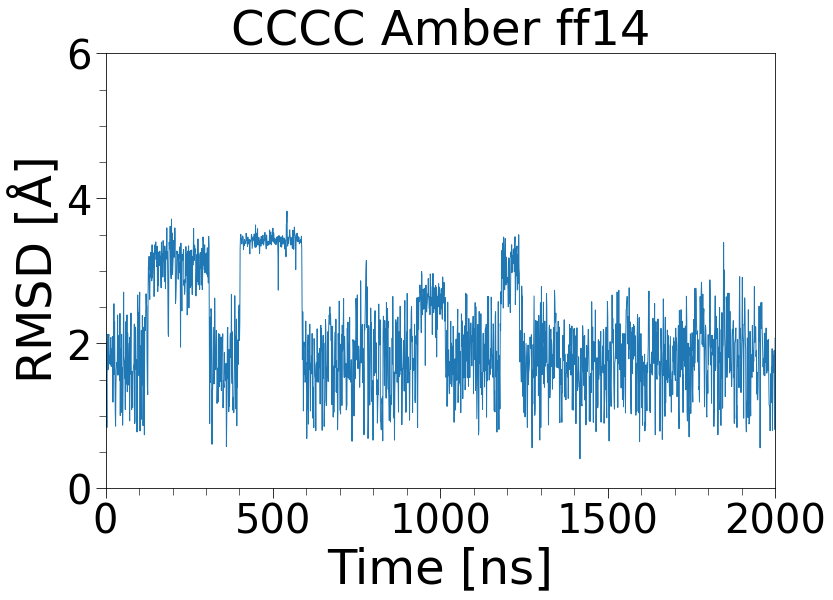

In [40]:
# calculate
rmsd = list(bb.functions.rmsd_traj(ref_traj, traj))   
rmsd = np.array(rmsd) * UNIT_NM_TO_ANGSTROMS

x = np.arange(1, len(rg)+1) * CHECKPOINT_INTERVAL * STRIDE * UNIT_PS_TO_NS

# define
fig, ax = plt.subplots(figsize=(12, 8))

# title
ax.set_title(PLOT_TITLE)

# x-axis
ax.set_xlabel(r'Time [ns]')
#ax.xaxis.set_ticks(np.arange(0, 1, 0.2))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.set_xlim([0, len(x)]) 

# y-axis
ax.set_ylabel(r'RMSD [${\rm \AA}$]')
#ax.yaxis.set_ticks(np.arange(0, 1, 0.2))
#ax.yaxis.set_minor_locator(MultipleLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.set_ylim([0, 6])

# plot
ax.plot(x, rmsd, lw=1)

#plt.show()
plt.savefig("rmsd.png")

#### eRMSD time plot

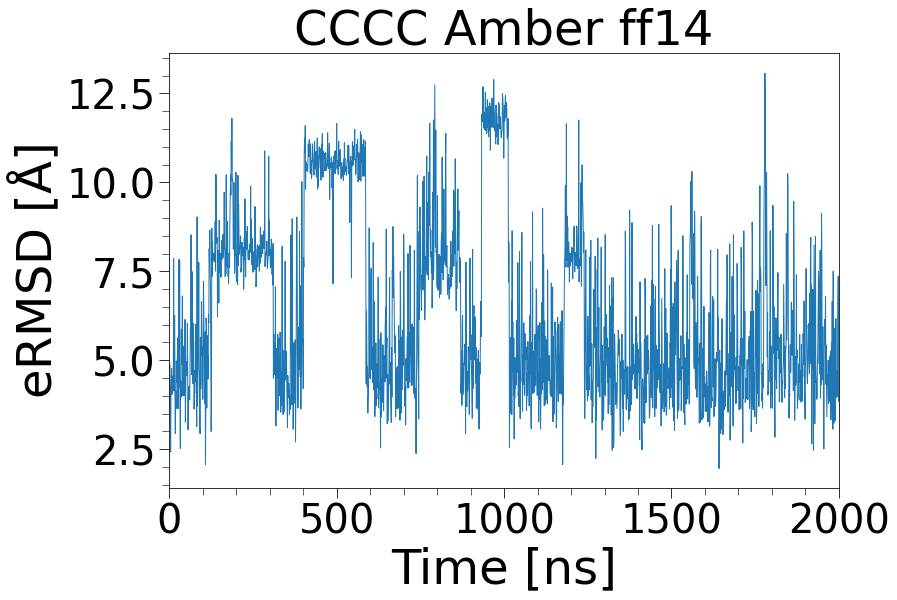

In [41]:
# calculate
ermsd = list(bb.functions.ermsd_traj(ref_traj, traj))   
ermsd = np.array(ermsd) * UNIT_NM_TO_ANGSTROMS


# define
fig, ax = plt.subplots(figsize=(12, 8))

# title
ax.set_title(PLOT_TITLE)

# x-axis
ax.set_xlabel(r'Time [ns]')
#ax.xaxis.set_ticks(np.arange(0, 1, 0.2))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.set_xlim([0, len(x)]) 

# y-axis
ax.set_ylabel(r'eRMSD [${\rm \AA}$]')
#ax.yaxis.set_ticks(np.arange(0, 1, 0.2))
#ax.yaxis.set_minor_locator(MultipleLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
#ax.set_ylim([0, 6])

# plot
ax.plot(x, ermsd, lw=1)

#plt.show()
plt.savefig("ermsd.png")

#### RMSD and eRMSD side-by-side plot

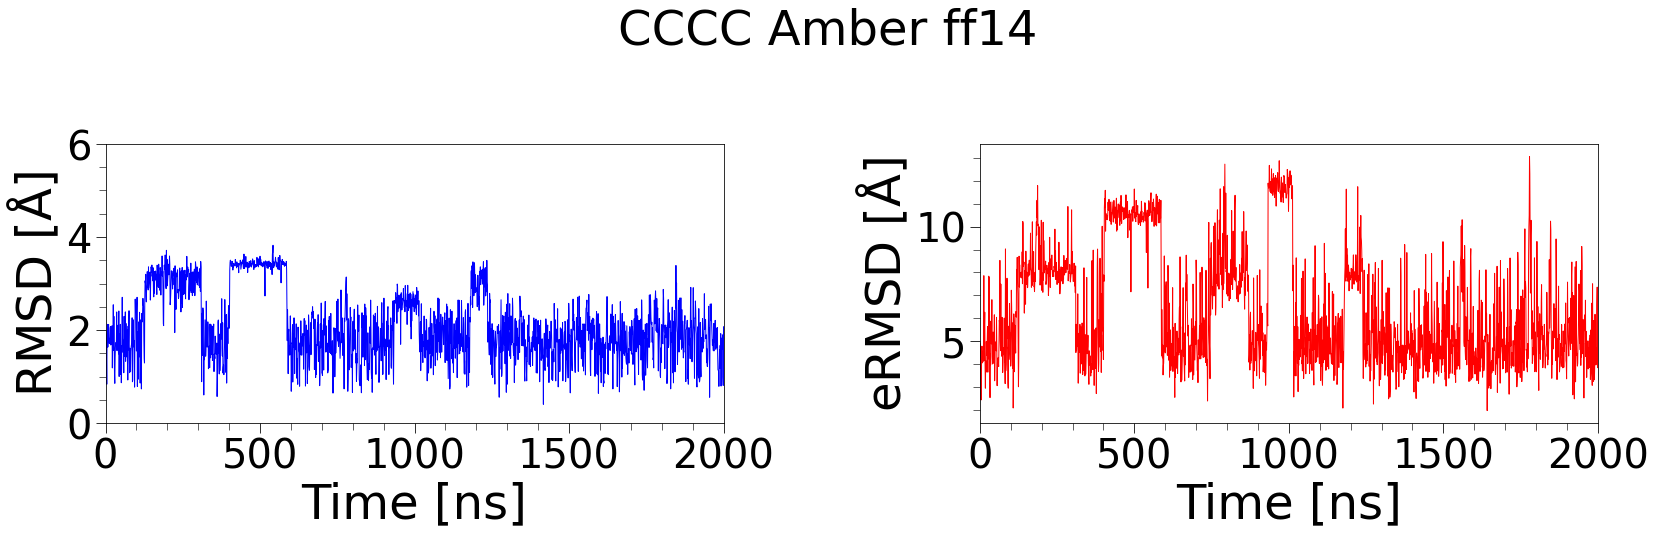

In [42]:
# define
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(24, 8))

# title
fig.suptitle(PLOT_TITLE)

# xy-axis (1)
ax1.set_xlabel(r'Time [ns]')
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.set_xlim([0, len(x)]) 
ax1.set_ylabel(r'RMSD [${\rm \AA}$]')
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.set_ylim([0, 6])

# xy-axis (2)
ax2.set_xlabel(r'Time [ns]')
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.set_xlim([0, len(x)]) 
ax2.set_ylabel(r'eRMSD [${\rm \AA}$]')
ax2.yaxis.set_minor_locator(AutoMinorLocator())
#ax2.set_ylim([0, 6])

# plot
ax1.plot(x, rmsd, lw=1, c='b')
ax2.plot(x, ermsd, lw=1, c='r')

plt.tight_layout()
#plt.show()
plt.savefig("rmsd_ermsd.png")

# Annotation

`stackings, pairings, res = bb.annotate(pdb)`  

returns three lists:

- a list of stacking interactions
- a list of pairing interactions
- the list of residue names following the usual convention RESNAME_RESNUMBER_CHAININDEX

`stackings` and `pairings` contain the list of interactions for the N frames in the PDB/trajectory file and it is organized in the following way: for a given frame there are interactions between residues with index pairings`[i][0][k][0]` and `pairings[i][0][k][1]`. The type of interaction is specified at the element `pairings[i][1][k]`.

### Decypher the annotation  ###
Base-pairing are classified according to the Leontis-Westhof classification, where 
- W = Watson-Crick edge
- H = Hoogsteeen edge 
- S= Sugar edge
- c/t = cis/trans
- XXx = when two bases are close in space, but they do not fall in any of the categories. This happens frequently for low-resolution structures or from molecular simulations.

WWc pairs between complementary bases are called WCc or GUc.  
Stacking are classified according to the MCannotate classification:
- ">>" Upward
- "<<" Downward 
- "<>" Outward
- "><" Inward



### Criteria for stacking/pairing ###
First, we consider only bases that are "close" in space, i.e. $R_{ij} < 1.7$ and $R_{ji} < 1.7$.  
$R_{ij} = (x_{ij}/5, y_{ij}/5, z_{ij}/3)$ is the SCALED position vector with components ${x,y,z}$ (in $\mathring{A}$) of base j constructed on base i.  
The criteria for *base-stacking* are the following:

$( |z_{ij}| \; AND \; |z_{ji}| > 2 \mathring{A} ) \; AND \;  
(\rho_{ij} \; OR\; \rho_{ji} < 2.5 \mathring{A}) \; AND\;  
(|\theta_{ij}| < 40^{\circ} ) $ 

where
- $ \rho_{ij} = \sqrt{x_{ij}^2 + y_{ij}^2} $  
- $\theta_{ij}$ = angle between the vectors normal to the base plane

The criteria for *base-pairing* are the following:  

non stacked AND $|\theta_{ij}| < 60^{\circ}$ AND (number of hydrogen bonds $> 0$)  
The number of hydrogen bonds is calculated as the number of donor-acceptor pairs with distance $< 3.3 \mathring{A}$. 
If bases are complementary and the number of hydrogen bonds is > 1 (AU/GU) or > 2 (GC), the pair is considered WCc (or GUc).

- cis/trans is calculated according to the value of the dihedral angle defined by $C1'_{i}-N1/N9_{i}-N1/N9_{j}-C1'_{j}$
- edges are definded according to the value of $\psi = \arctan{(\hat{y}_{ij}/\hat{x}_{ij})}$. 
    1. Watson-Crick edge: $0.16 <\psi \le 2.0 rad$ 
    2. Hoogsteen edge:  $2.0 <\psi \le 4.0 rad $. 
    3. Sugar edge: $\psi > 4.0, \psi \le 0.16$

    
**ATT!**
- These criteria are slightly different from the one used in other popular software for annotating three-dimensional structures (e.g. X3DNA, MCAnnotate, Fr3D, etc.). From my experience, all these packages give slightly different results, especially for non-Watson-Crick base-pairs.
- Stacking is also problematic, as it relies on arbitrary criteria.
- In all cases, criteria for stacking and pairing were calibrated to work well for high resolution structures. These criteria might not be optimal for low-resolution structures and to describe nearly-formed interactions such the ones that are often encountered in molecular simulations.

### Dot-bracket annotation ###

From the list of base-pairing, we can obtain the dot-bracket annotation using the function
```python
dotbracket = bb.dot_bracket(pairings,res)
```
this function returns a string for each frame in the PDB/simulation. Let's see this in action:


#### minimized structure

In [43]:
stackings, pairings, res = bb.annotate(ref_pdb, topology=init_pdb)

# Loading ../../eq/min.pdb 


In [44]:
# list base pairings
print("BASE-PAIRS")
for p in range(len(pairings[0][0])):
    res1 = res[pairings[0][0][p][0]]
    res2 = res[pairings[0][0][p][1]]
    interaction =  pairings[0][1][p]
    print("%10s %10s %4s" % (res1,res2,interaction))

# list base-stackings
print("STACKING")
for p in range(len(stackings[0][0])):
    res1 = res[stackings[0][0][p][0]]
    res2 = res[stackings[0][0][p][1]]
    interaction =  stackings[0][1][p]
    print("%10s %10s %4s" % (res1,res2,interaction))

BASE-PAIRS
STACKING
     C_1_0      C_2_0   >>
     C_2_0      C_3_0   >>
     C_3_0      C_4_0   >>


#### equilibration

In [49]:
stackings, pairings, res = bb.annotate_traj(eq_traj)

for i in range(len(stackings)):
    #print(stackings[i])
    stacking_residue_index = stackings[i][0]
    stacking_pattern = stackings[i][1]
    
    # A-form
    if stacking_pattern == ['>>', '>>', '>>']:
        print(stacking_pattern)

['>>', '>>', '>>']
['>>', '>>', '>>']
['>>', '>>', '>>']
['>>', '>>', '>>']
['>>', '>>', '>>']
['>>', '>>', '>>']
['>>', '>>', '>>']
['>>', '>>', '>>']
['>>', '>>', '>>']
['>>', '>>', '>>']
['>>', '>>', '>>']
['>>', '>>', '>>']
['>>', '>>', '>>']
['>>', '>>', '>>']
['>>', '>>', '>>']
['>>', '>>', '>>']
['>>', '>>', '>>']
['>>', '>>', '>>']
['>>', '>>', '>>']
['>>', '>>', '>>']
['>>', '>>', '>>']
['>>', '>>', '>>']
['>>', '>>', '>>']
['>>', '>>', '>>']
['>>', '>>', '>>']
['>>', '>>', '>>']
['>>', '>>', '>>']
['>>', '>>', '>>']
['>>', '>>', '>>']
['>>', '>>', '>>']
['>>', '>>', '>>']
['>>', '>>', '>>']
['>>', '>>', '>>']
['>>', '>>', '>>']
['>>', '>>', '>>']
['>>', '>>', '>>']
['>>', '>>', '>>']
['>>', '>>', '>>']
['>>', '>>', '>>']
['>>', '>>', '>>']
['>>', '>>', '>>']
['>>', '>>', '>>']
['>>', '>>', '>>']
['>>', '>>', '>>']
['>>', '>>', '>>']
['>>', '>>', '>>']
['>>', '>>', '>>']
['>>', '>>', '>>']
['>>', '>>', '>>']
['>>', '>>', '>>']
['>>', '>>', '>>']
['>>', '>>', '>>']
['>>', '>>',

#### production

Two possible orientations of two stacked bases result in four base-stacking types: upward (>>), downward (<<), outward (<>) and inward (><). Two arrows pointing in the same direction (upward and downward) corresponds to the stacking type in the canonical A-RNA double-helix. Upward or downward is chosen depending on which base is referred first (i.e. A>>B means B is stacked upward of A, or A is stacked downward of B). The two other types are less frequent in RNAs, respectively inward (A><B; A or B is stacked inward of, respectively B or A) and outward (A<>B; A or B is stacked outward of, respectively B or A). 

In [55]:
stackings, pairings, res = bb.annotate_traj(traj)
sugar_angles, _ = bb.pucker_rao_traj(traj)
bb_angles, _ = bb.backbone_angles_traj(traj, )


for i in range(len(stackings)):
    #print(stackings[i])
    stacking_residue_index = stackings[i][0]
    stacking_pattern = stackings[i][1]
    print(stacking_residue_index, stacking_pattern)
    
    
    
    # AMa: A-form major (3'-end backbone alpha-torsion +gauche)

        
    # AMi: A-form minor (3'-end backbone alpha-torsion is trans)
    
        
    # I: Intercaleted (nucleotide j inserts between and stacks against nb i and i+1)
    
    
    # F1/F4: Nucleotide-1 and -4 flipped (ribose ring of the terminal nucleotide adopts the C2'-endo configuration and the base is flipped away from the other three)
    
    
    # O: Others (all others)

[[0, 1], [1, 2], [2, 3]] ['>>', '>>', '>>']
[[0, 1], [1, 2]] ['>>', '>>']
[[0, 1], [1, 2], [2, 3]] ['>>', '>>', '>>']
[[0, 1], [1, 2]] ['>>', '>>']
[[0, 1], [1, 2], [2, 3]] ['>>', '>>', '>>']
[[0, 1], [1, 2], [2, 3]] ['>>', '>>', '>>']
[[0, 1], [1, 2], [2, 3]] ['>>', '>>', '>>']
[[0, 1], [1, 2], [2, 3]] ['>>', '>>', '>>']
[[0, 1], [1, 2], [2, 3]] ['>>', '>>', '>>']
[[0, 1], [1, 2], [2, 3]] ['>>', '>>', '>>']
[[0, 1], [1, 2]] ['>>', '>>']
[[0, 1], [1, 2], [2, 3]] ['>>', '>>', '>>']
[[1, 2], [2, 3]] ['>>', '>>']
[[0, 1], [1, 2], [2, 3]] ['>>', '>>', '>>']
[[0, 1], [1, 2], [2, 3]] ['>>', '>>', '>>']
[[0, 1], [1, 2]] ['>>', '>>']
[[0, 1], [1, 2], [2, 3]] ['>>', '>>', '>>']
[[0, 1], [1, 2], [2, 3]] ['>>', '>>', '>>']
[[0, 1], [1, 2], [2, 3]] ['>>', '>>', '>>']
[[0, 1], [1, 2], [2, 3]] ['>>', '>>', '>>']
[[0, 1], [1, 2], [2, 3]] ['>>', '>>', '>>']
[[0, 1], [1, 2]] ['>>', '>>']
[[0, 1], [1, 2], [2, 3]] ['>>', '>>', '>>']
[[0, 1], [1, 2], [2, 3]] ['>>', '>>', '>>']
[[1, 2], [2, 3]] ['>>', '>>'

In [58]:
bb_angles.shape

(2000, 4, 7)

In [52]:
# move from -pi,pi to 0-2pi range
a = np.copy(angles)
a[np.where(a<0.0)] += 2.*np.pi

# from radians to deg
a *= 180.0/np.pi

2000

# J-Coupling